# Bias Analysis with Hierachical Neural Networks

## 1. Analysis of the age group bias

In this part, we will build a model, which has the goal to investigate, in which way the **age groups affect the choice of transport**. How this is done will be explained later in detail. The variable of age has been chosen, as it comes with a lot of information: older people are generally more affluent, and less agile. Moreover, does the age contain information about individual families; it is more probable, that a 30-year-old has a 5-year-old daughter as is the case with a 60-year-old.

### 1.1 Data Preperation

In [1]:
from load_data import make_datasets3

X, Y, n_cat, n_ind, ind, labels, _ = make_datasets3(10000)

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
import seaborn as sns
import torch

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam

import warnings
#warnings.filterwarnings("ignore", category=FutureWarning)

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

In [ ]:
train_perc = 0.66 # percentage of training data
split_point = int(train_perc*len(Y))
perm = np.random.permutation(len(Y))
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
ind_train = ind[ix_train]
ind_test = ind[ix_test]
y_train = Y[ix_train]
y_test = Y[ix_test]
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

num train: 6600
num test: 3400


### 1.2 Baseline: Sklearn Regression Model

We run a simple Sklearn regression model to compare the achieved scores to. This model will be the benchmark for our model.

In [ ]:
# create and fit logistic regression model
logreg = linear_model.LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000)
logreg.fit(X_train, y_train)

# make predictions for test set
y_hat = logreg.predict(X_test)
print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))

predictions: [1. 1. 1. ... 1. 0. 1.]
true values: [1. 1. 1. ... 1. 0. 1.]
Accuracy: 0.775


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

         0.0       0.69      0.73      0.71       858
         1.0       0.82      0.89      0.85      2225
         2.0       0.34      0.08      0.13       191
         3.0       0.47      0.06      0.10       126

    accuracy                           0.78      3400
   macro avg       0.58      0.44      0.45      3400
weighted avg       0.75      0.78      0.75      3400



The base model has an **accuracy of 77.5 %** and similar F1 scores. However, we see that the quality of the prediction is majorly dependent on the number of rows for each class. Therefore, we see worse prediction metrics for "2" (Bus) and "3" (Train) than for "0" (Bike) and "1" (Car). In the cell below, we show the distribution of the transport modes for this dataset. We can see, that we have an **imbalanced dataset**.

In [ ]:
pd.DataFrame(Y).value_counts().sort_index()/len(Y)

0.0    0.2501
1.0    0.6531
2.0    0.0568
3.0    0.0400
dtype: float64

In [ ]:
# Prepare data for Pyro model
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
ind_train = torch.tensor(ind_train).long()

<ipython-input-9-b6be2e0a6cbd>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ind_train = torch.tensor(ind_train).long()


### 1.3 NNet with age group bias

The following model is a nnet which receives all the X columns as input data expect for the age groups. The **age** groups (grouped by 10 year spans) shall be **modeled with a hierchical intercept alpha and interpreted afterwards**. By doing so, we wish to get insights, how age determines the choice of mode, when all other parameters are kept out and modelled in the black box. The **generative process** denotes as following:
1. Draw neural network parameters $\theta \sim N(\theta| 0,$
2. For each travel mode $c \in \{1, ..., C\}$
 *  Draw global intercept mean $\mu_c \sim \mathcal{N}(\mu_c | 0, \sigma_{\alpha_c}^2)$
 *  Draw global intercept variance $\sigma_c \sim HalfCauchy(\sigma_c | 0, \sigma_{\alpha_c}^2)$
 * For each individual/city $l \in \{1, ..., L\}$
 * Draw $\alpha_{l,c} \sim \mathcal{N}(\alpha_{l,c} | \mu_c, \sigma_c)$
3. For each data point $n=\{1,...,N\}$
 * Draw target class $y_n \sim Multinomial(y_n | SoftMax(f_{nnet}(x_n) +\alpha_{l,c}))$

where $f_{nnet(x_n)}$ is a neural network.

As the only difference between the two models which we built in this notebook the intercept is, are the generative process and the PGM are the same and not shown twice.

The **PGM** then looks like this:

## PGM
![pgm](Pictures/PGM_new.png)


In [ ]:
#NNet definition given by professors
class FFNN(torch.nn.Module):
    def __init__(self, n_in, n_hidden, n_out):
        super(FFNN, self).__init__()
        
        # Architecture
        self.in_layer = torch.nn.Linear(n_in, n_hidden)
        self.h_layer = torch.nn.Linear(n_hidden, n_hidden)
        self.out_layer = torch.nn.Linear(n_hidden, n_out)
        
        # Activation functions
        self.tanh = torch.nn.Tanh()
        
    def forward(self, X):
        # Forward pass
        X = self.tanh(self.in_layer(X))
        X = self.tanh(self.h_layer(X))
        X = self.out_layer(X)
        
        return X

Little note: it was not possible to sample alpha with a pyro.plate in the model. When alpha is drawn with a pyro.plate in this hierarchical model with a nnet, an error is created. The error occurs when running the predictive module. The "X" is **increasing from 2D to 3D** for unknown reasons and this is **causing an error in the class FFNN**, as it is expecting a 2D shape. We could fix this problem by using a for loop to sample alpha and by extracting all the 9 alphas for all age groups one by one.

In [ ]:
def DNN_bias(X, ind, n_cat, n_ind, obs=None):
    # define the input dimension with the amout of columns we got
    input_dim = X.shape[1]

    # initialize the neural network
    torch_model = FFNN(n_in=input_dim, n_hidden=3, n_out=n_cat)  

    # to make the model baysian, priors are assigned for all parameters
    priors = {}
    for name, par in torch_model.named_parameters():  
        priors[name] = dist.Normal(torch.zeros(*par.shape), torch.ones(*par.shape)).to_event()

    bayesian_model = pyro.random_module('bayesian_model', torch_model, priors)

    # Initialize the model
    sampled_model = bayesian_model()                                           

    
    # Defining the hierachical NNet model starts here

    # Draw a prior for the bias mean. For sigma, different values have been used and it was found, that
    # 1 is the most adequate chocice
    alpha_mu = pyro.sample("alpha_mu", dist.Normal(torch.zeros(n_cat), 
                                    1*torch.ones(n_cat)).to_event()) 
    
    # Draw a prior for the bias variance
    alpha_sigma  = pyro.sample("alpha_sigma",  dist.HalfCauchy(1*torch.ones(n_cat)).to_event())
    
    # Draw bias for each age group
    alpha = torch.zeros(n_ind, n_cat)
    for i in range(n_ind):
        alpha[i] = pyro.sample("alpha_%d"%i, dist.Normal(alpha_mu, alpha_sigma).to_event())

    # Combine bias with nnet
    with pyro.plate("data", X.shape[0]):
        nnet = sampled_model(X).squeeze(-1)
        logits = alpha[ind] + nnet
        y = pyro.sample("y", dist.Categorical(logits=logits), obs=obs) 

    return y, alpha

Besides variational inference, also mcmc methods have been tried to run. However, with the amount of variables and rows, the mcmc algorithms did not finish as they took too long. Therefore, only variational inference is presented here.

In [ ]:
# Define guide function
guide = AutoDiagonalNormal(DNN_bias)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 3000

# Setup the optimizer
adam_params = {"lr": 0.005}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=3)
svi = SVI(DNN_bias, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, ind_train, n_cat, n_ind, y_train) # changed ind_train-1 and y_train-1
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

/root/venv/lib/python3.8/site-packages/pyro/primitives.py:491: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  warnings.warn(
[0] ELBO: 11644.6
[500] ELBO: 4414.1
[1000] ELBO: 4226.4
[1500] ELBO: 4173.9
[2000] ELBO: 4155.7
[2500] ELBO: 4149.7


### 1.4 Prediction Quality

In [ ]:
# Prepare test data for Pyro
X_test = torch.tensor(X_test).float()

In [ ]:
from pyro.infer import Predictive

predictive = Predictive(DNN_bias, guide=guide, num_samples=2000,
                        return_sites=("y", "alpha_sigma"))
samples = predictive(X_test, ind_test, n_cat, n_ind)

y_samples = samples["y"].detach().numpy()

In [ ]:
y_hat = samples['y'].detach().numpy()

from scipy import stats as st
y_pred, _ = st.mode(y_hat)

print("Accuracy:", 1.0*np.sum((y_pred[0]) == y_test) / len(y_test))

Accuracy: 0.7767647058823529


In [ ]:
print(classification_report(y_test, y_pred[0]))

              precision    recall  f1-score   support

         0.0       0.68      0.76      0.72       858
         1.0       0.82      0.88      0.85      2225
         2.0       0.40      0.10      0.16       191
         3.0       0.50      0.06      0.11       126

    accuracy                           0.78      3400
   macro avg       0.60      0.45      0.46      3400
weighted avg       0.75      0.78      0.75      3400



We see, that we can reach an **accuracy of 77-78 %** and similar F1 scores. Sadly, we couldn't beat the baseline with this approach and have similar metrics regarding the quality of the prediction. We also see the same poor performance on classes with few rows, so the neural network couldn't perform better on that either.

### 1.5 Distributions of the priors

To analyze the posterior distribution, we get samples of our priors and all the 9 alphas as explained earlier.

In [ ]:
from pyro.infer import Predictive

predictive = Predictive(DNN_bias, guide=guide, num_samples=2000,
                        return_sites=("y", "alpha_0", "alpha_1", "alpha_2", "alpha_3", "alpha_4", "alpha_5", "alpha_6", "alpha_7", "alpha_8",
                         "alpha_mu", "alpha_sigma"))

samples = predictive(X_train, ind_train, n_cat, n_ind, y_train)

y_samples = samples["y"].detach().numpy()
alpha_mu_samples = samples["alpha_mu"].detach().numpy()
alpha_sigma_samples = samples["alpha_sigma"].detach().numpy()

for i in range(n_ind):
    globals()[f'alpha_samples{i}'] = samples["alpha_%d" %i].detach().numpy()

/root/venv/lib/python3.8/site-packages/pyro/primitives.py:491: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  warnings.warn(


In [ ]:
# The predictive module added an extra dimension, which is taken away again here
alpha_samples_0 = alpha_samples0.reshape((alpha_samples0.shape[0]*alpha_samples0.shape[1], alpha_samples0.shape[2]))
alpha_samples_1 = alpha_samples1.reshape((alpha_samples1.shape[0]*alpha_samples1.shape[1], alpha_samples1.shape[2]))
alpha_samples_2 = alpha_samples2.reshape((alpha_samples2.shape[0]*alpha_samples2.shape[1], alpha_samples2.shape[2]))
alpha_samples_3 = alpha_samples3.reshape((alpha_samples3.shape[0]*alpha_samples3.shape[1], alpha_samples3.shape[2]))
alpha_samples_4 = alpha_samples4.reshape((alpha_samples4.shape[0]*alpha_samples4.shape[1], alpha_samples4.shape[2]))
alpha_samples_5 = alpha_samples5.reshape((alpha_samples5.shape[0]*alpha_samples5.shape[1], alpha_samples5.shape[2]))
alpha_samples_6 = alpha_samples6.reshape((alpha_samples6.shape[0]*alpha_samples6.shape[1], alpha_samples6.shape[2]))
alpha_samples_7 = alpha_samples7.reshape((alpha_samples7.shape[0]*alpha_samples7.shape[1], alpha_samples7.shape[2]))
alpha_samples_8 = alpha_samples8.reshape((alpha_samples8.shape[0]*alpha_samples8.shape[1], alpha_samples8.shape[2]))

In [ ]:
# Adding all alphas together
alphas = np.stack((alpha_samples_0, alpha_samples_1, alpha_samples_2,alpha_samples_3, alpha_samples_4,alpha_samples_5,alpha_samples_6,alpha_samples_7,alpha_samples_8), axis=0)

We can see, that the distributions have **spread away from their original mean of 0**. This shows us, that **the model has learned**. Apart from that, we see more narrow distributions for the transport modes, where we have a lot of data: 0 (Bike) and 1 (Car). The distributions are wider and the model is less certain for 2 (Bus) and 3 (Train). This makes sense, as the model is **more certain about the predictions, for which it has more data** avaiable. Also, we see positive means for the more common modes (bike and car) and negative means for the less common modes (bus and train), which just shows that people tend to not choose the latter as often. All these observations indicate that the model is working properly.

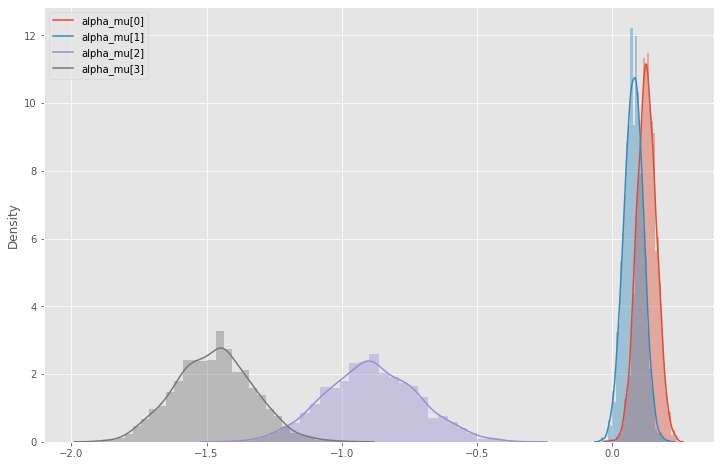

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

for c in range(n_cat):
    sns.distplot(alpha_mu_samples[:,0,c])
plt.legend(["alpha_mu[%d]" % c for c in range(n_cat)])
plt.show()

The variances of the distributions are showing a similar picture. The more data there is for each category, the more certain the model is. Therefore, the variance for the intercepts of cars and bicycles are narrower, leading to more precise predictions.

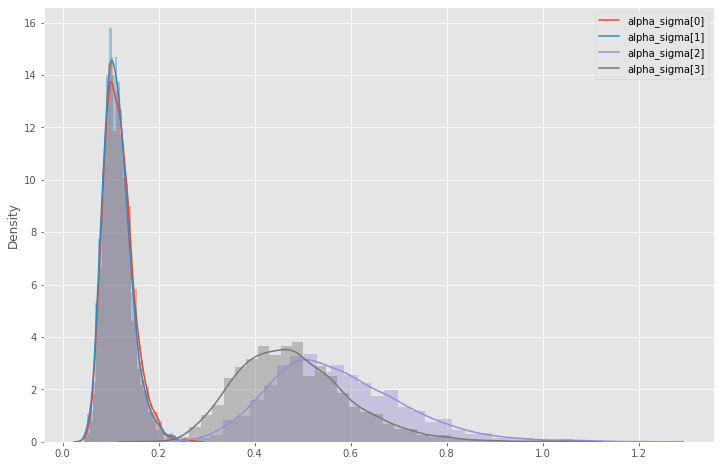

In [ ]:
for c in range(n_cat):
    sns.distplot(alpha_sigma_samples[:,0,c])
plt.legend(["alpha_sigma[%d]" % c for c in range(n_cat)])
plt.show()

In [ ]:
alphas = alphas.mean(axis=1)

### 1.6 Analysis of the intercepts

Finally, we shall analyze the intercept alpha for all age groups across the different transport modes. To describe the effects "alpha" has on the prediction, we will use the nouns "intercept" or "bias" interchangeably; we always **want to describe, how "alpha" is influencing the prediction** apart from the neural network black box.

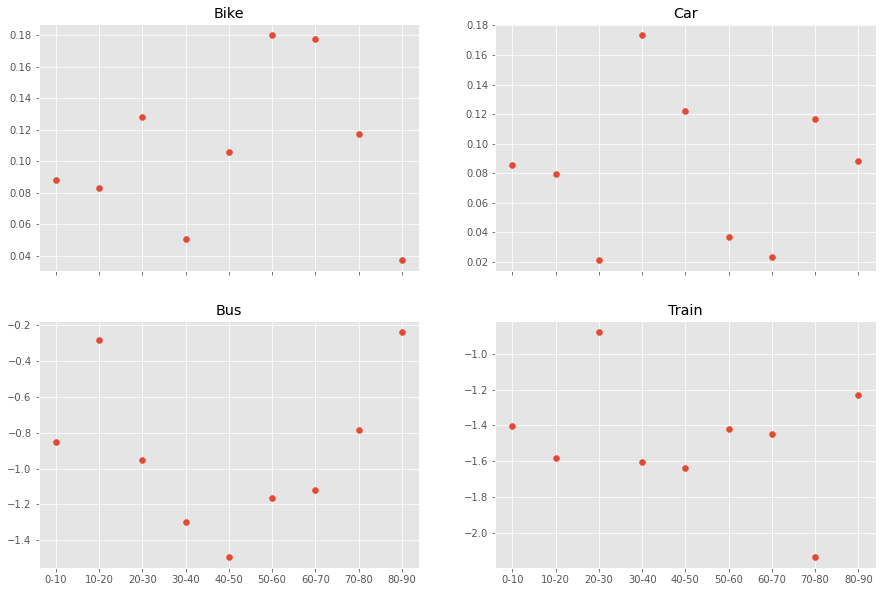

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(15,10))
modes =["Bike", "Car", "Bus", "Train"]
ax = ax.flatten()
for i in range(n_cat):    
    ax[i].scatter(range(n_ind), alphas[:,i]);
    ax[i].set_title(modes[i])
    plt.xticks(np.arange(n_ind), labels);

Above, you can see a graph for each transport mode and the bias towards this transport for each age group. Starting with the plot showing the bicycle bias, we see that it is not the young people who have the highest intercept for bicycles as one might expect, but the 50-70-year-olds. But from 70 on, the people start riding fewer bikes, and the 80-90-year-olds ride the least bicycle of all groups, which makes sense. 

The 30-50-year-olds are the group with the highest bias towards cars, which comes along with lower biases towards other transport modes. The 0-20-year-olds show an average alpha value, as they have probably a lot of trips with their parents even though they don't drive by themselves. The group with the lowest car bias is the 20-30-year-olds, which might be explained as especially in the early twenties, people might not have the money to afford a car.

The biases toward buses tell a simpler story: we see, that 0-10-year-olds already ride a lot of buses, probably as they go to school with them. 10-20-year-olds take the bus even more as they grow up and also take longer trips with it. Adults take the bus less as they have the possibilities to take other modes. The popularity of the bus is then rising again for old people, as they are getting less agile and can not drive a car or cycle.

The train biases are very similar for all age groups except for two: the 20-30-year-olds use this mode the most while 70-80-year-olds use it the least.

## 2. Analysis of the home city bias

In this part, we built a similar model as before. The difference will be, however, that **now the home city is modeled with a bias**. We picked this as a second variable, as it seems to be similarly important for the transport choice like the age. Big cities often have better public transport while smaller cities are more dependent on cars.

### 2.1 Data Preperation

In [ ]:
from load_data import make_datasets, make_datasets4

X,Y,n_cat, n_ind, ind_c, labels, _ = make_datasets4(10000)

ind = np.array(ind_c)

X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
data = (X - X_mean) / X_std
X = np.array(data)

In [ ]:
train_perc = 0.66 # percentage of training data
split_point = int(train_perc*len(Y))
perm = np.random.permutation(len(Y))
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
ind_train = ind[ix_train]
ind_test = ind[ix_test]
y_train = Y[ix_train]
y_test = Y[ix_test]
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

num train: 6600
num test: 3400


In [ ]:
# Prepare test data for Pyro
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
ind_train = torch.tensor(ind_train).long()

### 2.2 NNet with City Bias

In [ ]:
def DNN_city_bias(X, ind, n_cat, n_ind, obs=None):
    # define the input dimension with the amout of columns we got
    input_dim = X.shape[1]

    # initialize the neural network
    torch_model = FFNN(n_in=input_dim, n_hidden=3, n_out=n_cat) # Initialize the neural network from PyTorch 

    # to make the model baysian, priors are assigned for all parameters
    priors = {}
    for name, par in torch_model.named_parameters():    
        priors[name] = dist.Normal(torch.zeros(*par.shape), torch.ones(*par.shape)).to_event() 

    bayesian_model = pyro.random_module('bayesian_model', torch_model, priors)
    
    # Initialize the model
    sampled_model = bayesian_model()                                          


    # Defining the hierachical NNet model starts here

    # Draw a prior for the bias mean. For the priors, different values/factors have been used and it 
    # was found, that 1 is the most adequate chocice
    alpha_mu = pyro.sample("alpha_mu", dist.Normal(torch.zeros(n_cat), 
                                    1*torch.ones(n_cat)).to_event()) 
    
    # Draw a prior for the bias variance
    alpha_sigma  = pyro.sample("alpha_sigma",  dist.HalfCauchy(1*torch.ones(n_cat)).to_event()) # Prior for the bias standard deviation
    
    # Draw bias for each city
    alpha = torch.zeros(n_ind, n_cat)
    for i in range(n_ind):
        alpha[i] = pyro.sample("alpha_%d"%i, dist.Normal(alpha_mu, alpha_sigma).to_event()) # Draw the individual parameter for each individual

    # Combine bias with nnet
    with pyro.plate("data", X.shape[0]):
        nnet = sampled_model(X).squeeze(-1)
        logits = alpha[ind] + nnet
        y = pyro.sample("y", dist.Categorical(logits=logits), obs=obs) # If you use logits you don't need to do sigmoid

    return y, alpha

In [ ]:
# Define guide function
guide = AutoDiagonalNormal(DNN_city_bias)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 3000

# Setup the optimizer
adam_params = {"lr": 0.005}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=3)
svi = SVI(DNN_city_bias, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, ind_train, n_cat, n_ind, y_train) # changed ind_train-1 and y_train-1
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))


[0] ELBO: 10459.8
[500] ELBO: 4449.3
[1000] ELBO: 4333.4
[1500] ELBO: 4277.3
[2000] ELBO: 4267.1
[2500] ELBO: 4231.6


### 2.3 Prediction Quality

In [ ]:
X_test = torch.tensor(X_test).float()
predictive = Predictive(DNN_city_bias, guide=guide, num_samples=2000,
                        return_sites=("y", "alpha_sigma"))
samples = predictive(X_test, ind_test, n_cat, n_ind)

y_samples = samples["y"].detach().numpy()

y_hat = samples['y'].detach().numpy()

from scipy import stats as st
y_pred, _ = st.mode(y_hat)

print("Accuracy:", 1.0*np.sum((y_pred[0]) == y_test) / len(y_test))

Accuracy: 0.7861764705882353


In [ ]:
print(classification_report(y_test, y_pred[0]))

              precision    recall  f1-score   support

         0.0       0.73      0.71      0.72       860
         1.0       0.81      0.91      0.86      2239
         2.0       0.42      0.10      0.16       185
         3.0       0.33      0.03      0.06       116

    accuracy                           0.79      3400
   macro avg       0.57      0.44      0.45      3400
weighted avg       0.75      0.79      0.76      3400



The new model assumptions made the model perform a bit better. We can now reach a accuracy of nearly 79 %. This tells us, that in our test case the city is a bit more helpful for predicting the transport mode than the age group.

### 2.4 Distribution of the priors

In [ ]:
predictive = Predictive(DNN_city_bias, guide=guide, num_samples=2000,
                        return_sites=("y", "alpha_0", "alpha_1", "alpha_2", "alpha_3", "alpha_4", "alpha_5",
                         "alpha_6", "alpha_7", "alpha_8","alpha_9","alpha_10",
                         "alpha_mu", "alpha_sigma"))
samples = predictive(X_train, ind_train, n_cat, n_ind, y_train)


y_samples = samples["y"].detach().numpy()
alpha_mu_samples = samples["alpha_mu"].detach().numpy()
alpha_sigma_samples = samples["alpha_sigma"].detach().numpy()

for i in range(n_ind):
    globals()[f'alpha_samples{i}'] = samples["alpha_%d" %i].detach().numpy()

In [ ]:
alpha_samples_0 = alpha_samples0.reshape((alpha_samples0.shape[0]*alpha_samples0.shape[1], alpha_samples0.shape[2]))
alpha_samples_1 = alpha_samples1.reshape((alpha_samples1.shape[0]*alpha_samples1.shape[1], alpha_samples1.shape[2]))
alpha_samples_2 = alpha_samples2.reshape((alpha_samples2.shape[0]*alpha_samples2.shape[1], alpha_samples2.shape[2]))
alpha_samples_3 = alpha_samples3.reshape((alpha_samples3.shape[0]*alpha_samples3.shape[1], alpha_samples3.shape[2]))
alpha_samples_4 = alpha_samples4.reshape((alpha_samples4.shape[0]*alpha_samples4.shape[1], alpha_samples4.shape[2]))
alpha_samples_5 = alpha_samples5.reshape((alpha_samples5.shape[0]*alpha_samples5.shape[1], alpha_samples5.shape[2]))
alpha_samples_6 = alpha_samples6.reshape((alpha_samples6.shape[0]*alpha_samples6.shape[1], alpha_samples6.shape[2]))
alpha_samples_7 = alpha_samples7.reshape((alpha_samples7.shape[0]*alpha_samples7.shape[1], alpha_samples7.shape[2]))
alpha_samples_8 = alpha_samples8.reshape((alpha_samples8.shape[0]*alpha_samples8.shape[1], alpha_samples8.shape[2]))
alpha_samples_9 = alpha_samples9.reshape((alpha_samples9.shape[0]*alpha_samples9.shape[1], alpha_samples9.shape[2]))
alpha_samples_10 = alpha_samples10.reshape((alpha_samples10.shape[0]*alpha_samples10.shape[1], alpha_samples10.shape[2]))

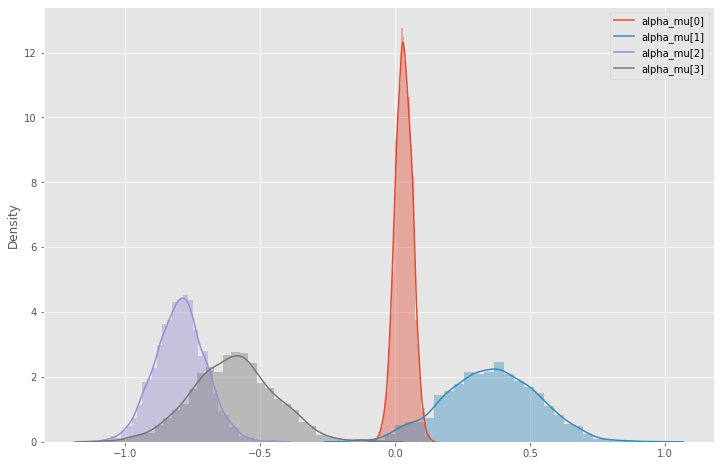

In [ ]:
for c in range(n_cat):
    sns.distplot(alpha_mu_samples[:,0,c])
plt.legend(["alpha_mu[%d]" % c for c in range(n_cat)])
plt.show()

We can see again, that the model clearly learned. However, for this model the picture regarding the mean is more nuanced. We see, that the mean for the bikes (alpha_mu[0]) is very narrow centered around 0. The bias mean of the cars (alpha_mu[1]) is again positive as it is the most popular transport mode. Trains and busses are again negative.

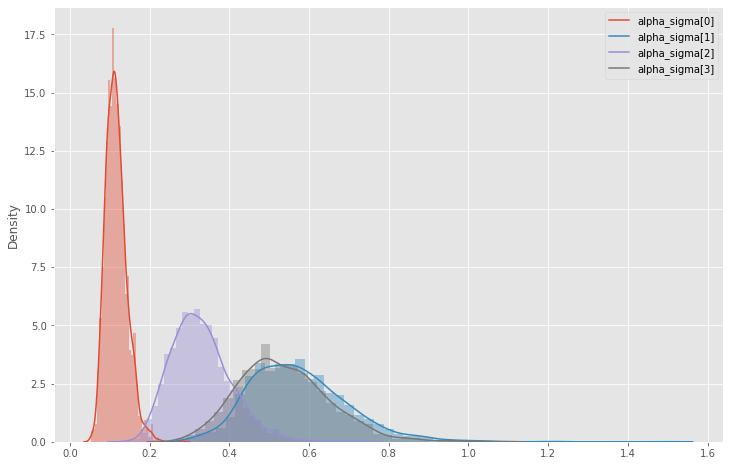

In [ ]:
for c in range(n_cat):
    sns.distplot(alpha_sigma_samples[:,0,c])
plt.legend(["alpha_sigma[%d]" % c for c in range(n_cat)])
plt.show()

### 2.5 Analysis of the intercepts

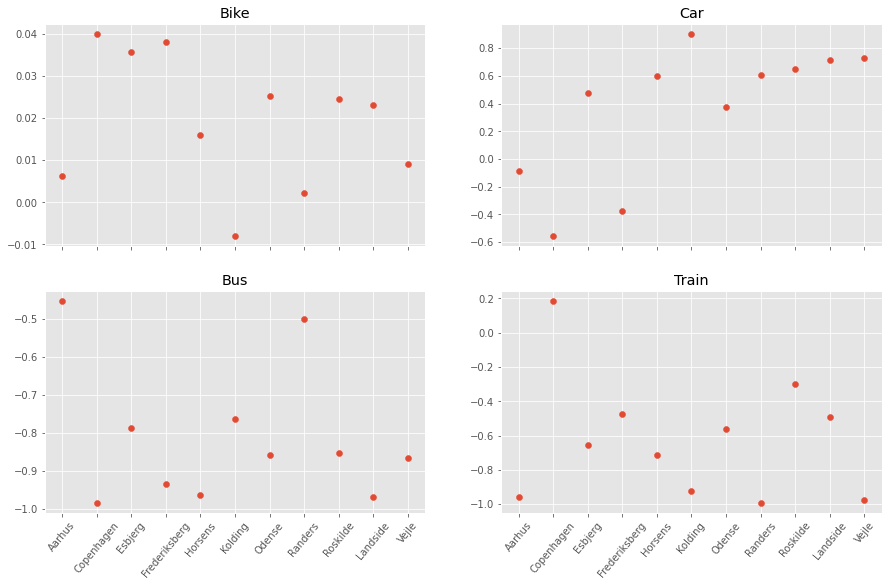

In [ ]:
alphas = np.stack((alpha_samples_0, alpha_samples_1, alpha_samples_2,alpha_samples_3, alpha_samples_4,alpha_samples_5,alpha_samples_6,alpha_samples_7,alpha_samples_8,alpha_samples_9,alpha_samples_10), axis=0)

alphas = alphas.mean(axis=1)

fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(15,9))
modes =["Bike", "Car", "Bus", "Train"]
ax = ax.flatten()
for i in range(n_cat):    
    ax[i].scatter(range(11), alphas[:,i]);
    ax[i].set_title(modes[i])
    ax[i].tick_params(axis="x", rotation=50)
    plt.xticks(np.arange(11), ['Aarhus', 'Copenhagen', 'Esbjerg', 'Frederiksberg', 'Horsens',
       'Kolding', 'Odense', 'Randers', 'Roskilde', 'Landside', 'Vejle']);


Little note: "Landside" includes all smaller cities, as we assume that they have similar transport infrastructure.

The graph tells us the following about the different cities. First, we want to talk about bicycles and the capital Copenhagen. **Copenhagen's highest bias towards bicycles** which was expected as people in the capital ride the most bike in Denmark as it can be seen in the statistics [here](https://cyclingsolutions.info/embassy/danish-cycling-statistics/). **Trains are very popular**, too which makes sense with the **dense s-train and metro grid**. Therefore, cars and buses are less popular in Copenhagen. Frederiksberg is pretty similar, with the difference that trains are less popular in this commune.

In the statistics, it is shown, that people from Odense also ride a lot of bikes, which can also be seen in our graph. However, people from Aarhus also bike more than the average Dane according to the statistic while in our graph, they are in the mid-field. The reason for this could be the following: we also see a high bias towards busses in Aarhus, and as a city can not have a high intercept for all modes, this could influence this bicycle bias. This example shows us, that care must be taken when interpreting these graphs and one alone does not show the whole picture.

Continuing with the biases towards **car usage**, we see a clear picture: in the **urban areas like Copenhagen/Frederiksberg and Aarhus, we have a significantly lower bias than in the smaller cities**. For the busses, we see that in some cities people use it a lot like in Aarhus and Randers, while there are very different usages among the other cities. The picture for the train biases is also more complex than for the cars. As mentioned, people in Copenhagen use the train a lot while people from other communes use it less (also probably because they have less train infrastructure).

# Limitations of the approach

In this notebook, we built two different models. Both were hierarchical models which combined a bias with a neural network. We could derive insightful conclusions and the model is performing well in terms of accuracy, even though this is not very hard as we have a very imbalanced dataset. A shortcoming of this approach is, however, that you can not interpret anything apart from the intercept, as the rest of the model is a black-box neural network. Therefore, we decided to not stop here and built yet another model, which also allows for some more modifications and interpretability. 

In other words: we have fully implemented the idea, we presented in the first hand-in and are satisfied with the results, but as a part of our journey, we recognized the shortcomings and therefore wanted to continue with a new model. We do not see this as an issue, as **sometimes in academia you investigate in one direction, but have to realize that another approach might be better**. In the next notebooks, you will see models without neural networks.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=33ff09b2-3bea-450e-b86b-71092420bc76' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>